In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import lightgbm as lgb
import copy
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report, precision_recall_curve                                                          # 層化k分割

import warnings
warnings.filterwarnings('ignore')

In [2]:
data_set = pd.read_csv('../input/pump-sensor-data/sensor.csv')

# データセット分析・可視化

In [36]:
data_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220320 entries, 0 to 220319
Data columns (total 55 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   Unnamed: 0      220320 non-null  int64  
 1   timestamp       220320 non-null  object 
 2   sensor_00       210112 non-null  float64
 3   sensor_01       219951 non-null  float64
 4   sensor_02       220301 non-null  float64
 5   sensor_03       220301 non-null  float64
 6   sensor_04       220301 non-null  float64
 7   sensor_05       220301 non-null  float64
 8   sensor_06       215522 non-null  float64
 9   sensor_07       214869 non-null  float64
 10  sensor_08       215213 non-null  float64
 11  sensor_09       215725 non-null  float64
 12  sensor_10       220301 non-null  float64
 13  sensor_11       220301 non-null  float64
 14  sensor_12       220301 non-null  float64
 15  sensor_13       220301 non-null  float64
 16  sensor_14       220299 non-null  float64
 17  sensor_15 

In [3]:
# 不必要なデータを削除
data_set = data_set.drop(['sensor_15', 'Unnamed: 0'], axis=1)

In [6]:
data_set.head()

,timestamp,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,...,sensor_43,sensor_44,sensor_45,sensor_46,sensor_47,sensor_48,sensor_49,sensor_50,sensor_51,machine_status
0,2018-04-01 00:00:00,2.465394,47.09201,53.2118,46.310760,634.3750,76.45975,13.41146,16.13136,15.56713,...,41.92708,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834,243.0556,201.3889,NORMAL
1,2018-04-01 00:01:00,2.465394,47.09201,53.2118,46.310760,634.3750,76.45975,13.41146,16.13136,15.56713,...,41.92708,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834,243.0556,201.3889,NORMAL
2,2018-04-01 00:02:00,2.444734,47.35243,53.2118,46.397570,638.8889,73.54598,13.32465,16.03733,15.61777,...,41.66666,39.351852,65.39352,51.21528,38.194443,155.9606,67.12963,241.3194,203.7037,NORMAL
3,2018-04-01 00:03:00,2.460474,47.09201,53.1684,46.397568,628.1250,76.98898,13.31742,16.24711,15.69734,...,40.88541,39.062500,64.81481,51.21528,38.194440,155.9606,66.84028,240.4514,203.1250,NORMAL
4,2018-04-01 00:04:00,2.445718,47.13541,53.2118,46.397568,636.4583,76.58897,13.35359,16.21094,15.69734,...,41.40625,38.773150,65.10416,51.79398,38.773150,158.2755,66.55093,242.1875,201.3889,NORMAL


In [7]:
# RECOVERINGを正常/異常のどちらに含めるか
# '復旧中'の意味であれば、正常とは言えないため異常と識別しても良い?

data_set['machine_status'].value_counts()

machine_status
NORMAL        205836
RECOVERING     14477
BROKEN             7
Name: count, dtype: int64

In [14]:
data_set[data_set.machine_status == 'BROKEN']

,timestamp,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,...,sensor_43,sensor_44,sensor_45,sensor_46,sensor_47,sensor_48,sensor_49,sensor_50,sensor_51,machine_status
17155,2018-04-12 21:55:00,0.000000,53.342010,52.821180,43.402775,202.526031,49.79289,3.219039,16.890910,16.869210,...,50.78125,50.92593,51.215280,50.636570,46.006940,409.143500,121.527800,401.909700,324.6528,BROKEN
24510,2018-04-18 00:30:00,1.093982,42.534720,47.699650,41.449650,206.038757,60.30106,12.304690,15.154800,14.185470,...,42.70833,34.72222,31.539350,34.432870,33.275460,59.895830,44.560180,177.662000,183.7384,BROKEN
69318,2018-05-19 03:18:00,2.258796,47.265630,52.734370,43.446178,200.115738,66.14643,13.592300,15.914350,15.147570,...,39.06250,35.01157,37.905090,39.062500,45.428240,144.675900,49.768520,246.238400,257.5231,BROKEN
77790,2018-05-25 00:30:00,2.321759,47.482640,51.475693,42.795135,612.152800,67.30158,14.062500,16.608800,15.943290,...,202.34370,65.68287,57.870370,127.893500,153.935200,155.381900,65.682870,220.196800,267.3611,BROKEN
128040,2018-06-28 22:00:00,0.364005,40.190970,45.225690,40.190971,201.368622,0.00000,11.335360,15.270540,15.183740,...,32.29166,28.06713,28.067129,29.513889,29.224537,29.224537,29.513889,32.407406,NaN,BROKEN
141131,2018-07-08 00:11:00,0.001968,45.138890,52.907990,45.355900,500.000000,1.40131,0.028935,0.036169,0.036169,...,36.19791,37.32639,35.300930,38.194440,43.402780,99.537030,44.849540,192.129600,174.7685,BROKEN
166440,2018-07-25 14:00:00,2.318808,45.833332,52.994790,43.880210,420.503448,72.52040,14.185470,16.247110,15.697340,...,51.30208,52.10200,52.662040,67.129630,43.981480,230.324100,69.733800,NaN,205.7292,BROKEN


In [15]:
data_set[data_set.machine_status == 'RECOVERING'].head()

,timestamp,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,...,sensor_43,sensor_44,sensor_45,sensor_46,sensor_47,sensor_48,sensor_49,sensor_50,sensor_51,machine_status
17156,2018-04-12 21:56:00,0.0,53.55902,52.77777,43.402775,204.725098,53.74214,3.045428,17.42621,15.740740,...,49.47916,50.34722,51.21528,49.18982,49.47917,431.7130,133.1019,419.2708,341.7245,RECOVERING
17157,2018-04-12 21:57:00,0.0,53.55902,52.77777,43.402775,201.137131,52.49996,7.537616,13.53443,9.324364,...,48.17708,49.76852,50.92593,48.03241,53.81944,451.3889,140.0463,433.1597,466.1458,RECOVERING
17158,2018-04-12 21:58:00,0.0,52.77777,52.69097,43.402770,204.030655,57.19875,7.609953,16.60880,16.203700,...,46.87500,48.03241,50.34722,47.45370,58.15972,466.4352,144.9653,442.7083,366.0301,RECOVERING
17159,2018-04-12 21:59:00,0.0,52.60416,52.73437,43.446180,203.567688,50.96181,7.573785,16.70284,16.160300,...,45.83333,47.45370,49.76852,46.58565,63.65741,474.8264,149.0162,449.6528,374.4213,RECOVERING
17160,2018-04-12 22:00:00,NaN,52.51736,52.69097,43.446180,203.567688,49.78948,7.559317,16.56539,16.239870,...,44.27083,46.29630,48.03241,45.13889,75.23148,477.7199,162.6157,448.7847,356.1921,RECOVERING


In [4]:
# データ分割
train_set = copy.deepcopy(data_set.iloc[:int(len(data_set)/2)])
test_set = copy.deepcopy(data_set.iloc[int(len(data_set)/2):])

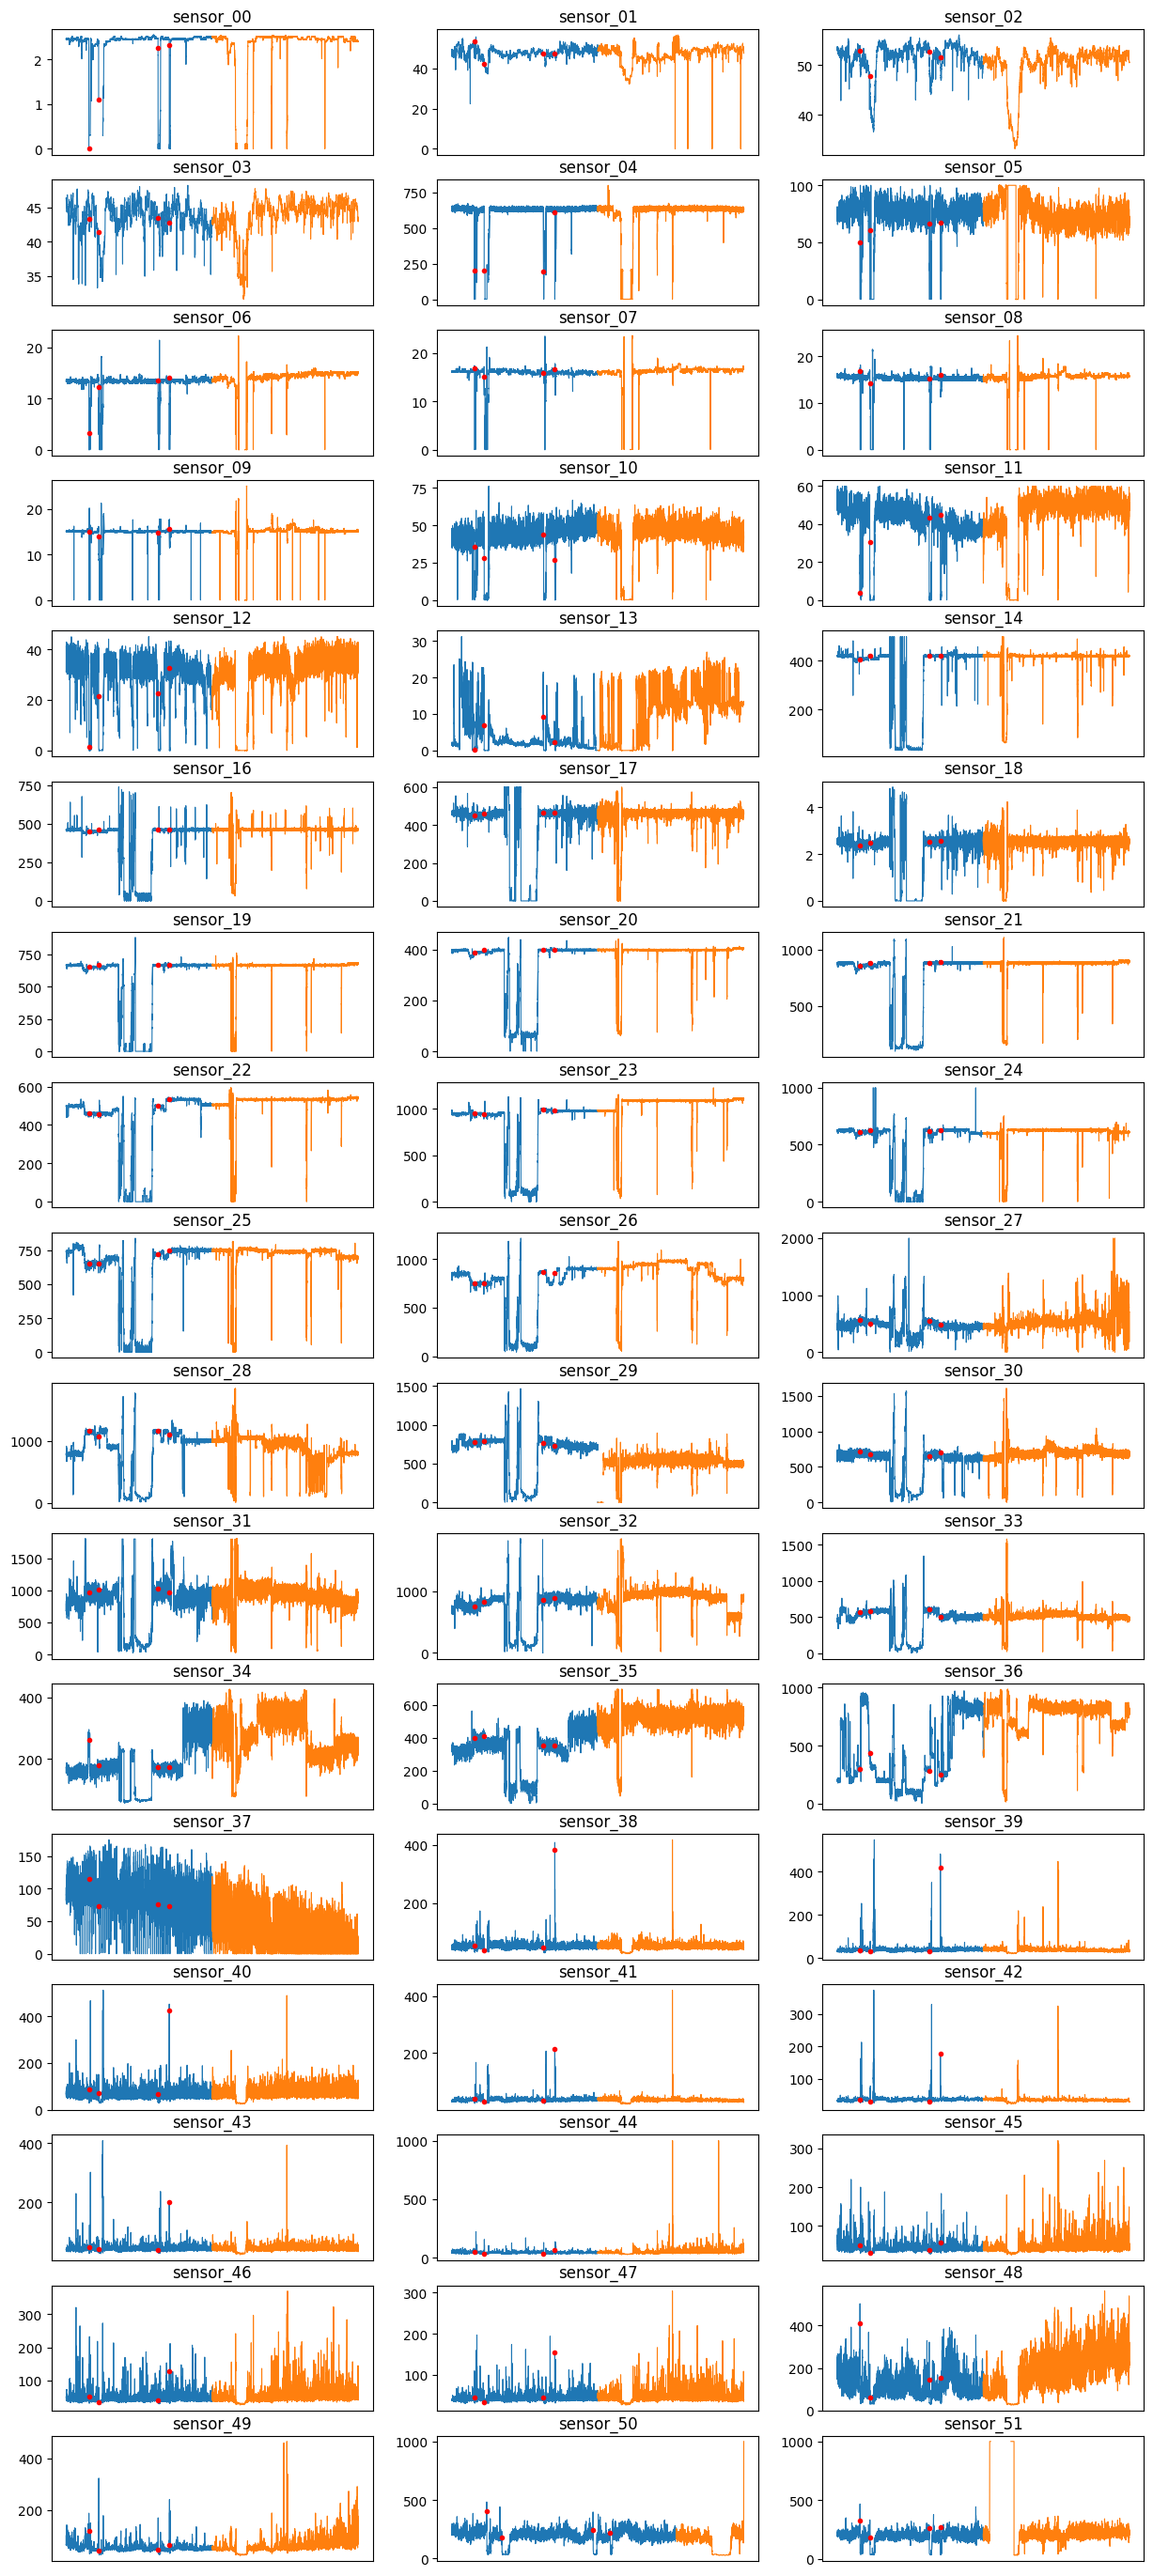

In [5]:
# センサーごとの故障ポイント
x1 = len(train_set)
x2 = len(test_set)
broken_id = train_set[train_set.machine_status=='BROKEN'].index

fig, axes = plt.subplots(17, 3, figsize=(15, 35))
for ax, sensor in zip(axes.ravel(), data_set.columns[1:-1]):
    y1 = train_set[sensor]
    y2 = test_set[sensor]
    ax.set_title(sensor)
    ax.set_xticks([])
    ax.plot(range(x1), y1, linewidth=0.8, zorder=1)
    ax.plot(range(x1, x1+x2), y2, linewidth=0.8, zorder=1)
    ax.scatter(broken_id, y1[broken_id], marker='.', c='red', zorder=2)

sensor_00        -0.014869
sensor_01        -0.000583
sensor_02        -0.000896
sensor_03        -0.002298
sensor_04        -0.014686
sensor_05        -0.003860
sensor_06        -0.006053
sensor_07         0.001337
sensor_08         0.001544
sensor_09         0.000485
sensor_10        -0.003919
sensor_11        -0.004899
sensor_12        -0.005521
sensor_13         0.001852
sensor_14         0.003078
sensor_16         0.002984
sensor_17         0.002543
sensor_18         0.002320
sensor_19         0.003077
sensor_20         0.003065
sensor_21         0.003045
sensor_22         0.002712
sensor_23         0.003084
sensor_24         0.003000
sensor_25         0.002427
sensor_26         0.002372
sensor_27         0.002107
sensor_28         0.004478
sensor_29         0.002568
sensor_30         0.003480
sensor_31         0.003216
sensor_32         0.002064
sensor_33         0.003043
sensor_34         0.000754
sensor_35         0.002299
sensor_36        -0.002131
sensor_37        -0.001005
s

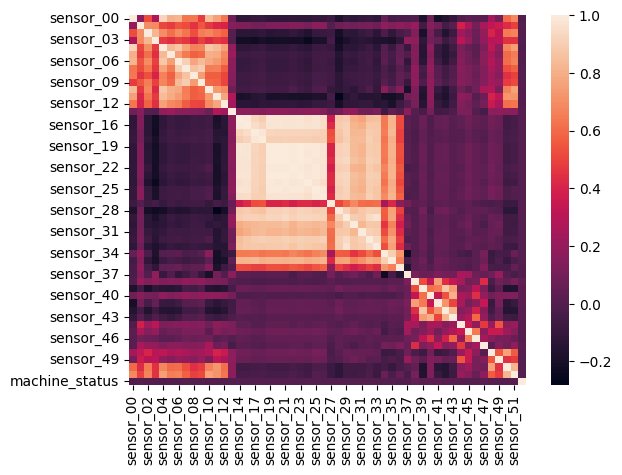

In [42]:
# 各特徴量同士の相関を確認 (訓練データ)
# 各特徴量ごとの相関から、4つのグループに次元削減できそう?
heat_set = train_set.drop(['timestamp'], axis=1)
heat_set['machine_status'][(heat_set.machine_status == 'NORMAL') | (heat_set.machine_status == 'RECOVERING')] = 0
heat_set['machine_status'][heat_set.machine_status == 'BROKEN'] = 1
sns.heatmap(heat_set.corr())

# 各特徴量とターゲット変数との相関係数 (訓練データ)
# 訓練データ11万に対し異常データは4つのみである為、基本的に相関は小さい
sonsor_corr = heat_set.corr().loc['machine_status']
print(sonsor_corr)

In [5]:
# RECOVERINGも異常とする

data_set['machine_status'][data_set.machine_status == 'NORMAL'] = 0
data_set['machine_status'][(data_set.machine_status == 'BROKEN') | (data_set.machine_status == 'RECOVERING')] = 1
data_set['machine_status'] = data_set['machine_status'].astype('int64')

# データ分割
train_set = copy.deepcopy(data_set.iloc[:int(len(data_set)/2)])
test_set = copy.deepcopy(data_set.iloc[int(len(data_set)/2):])

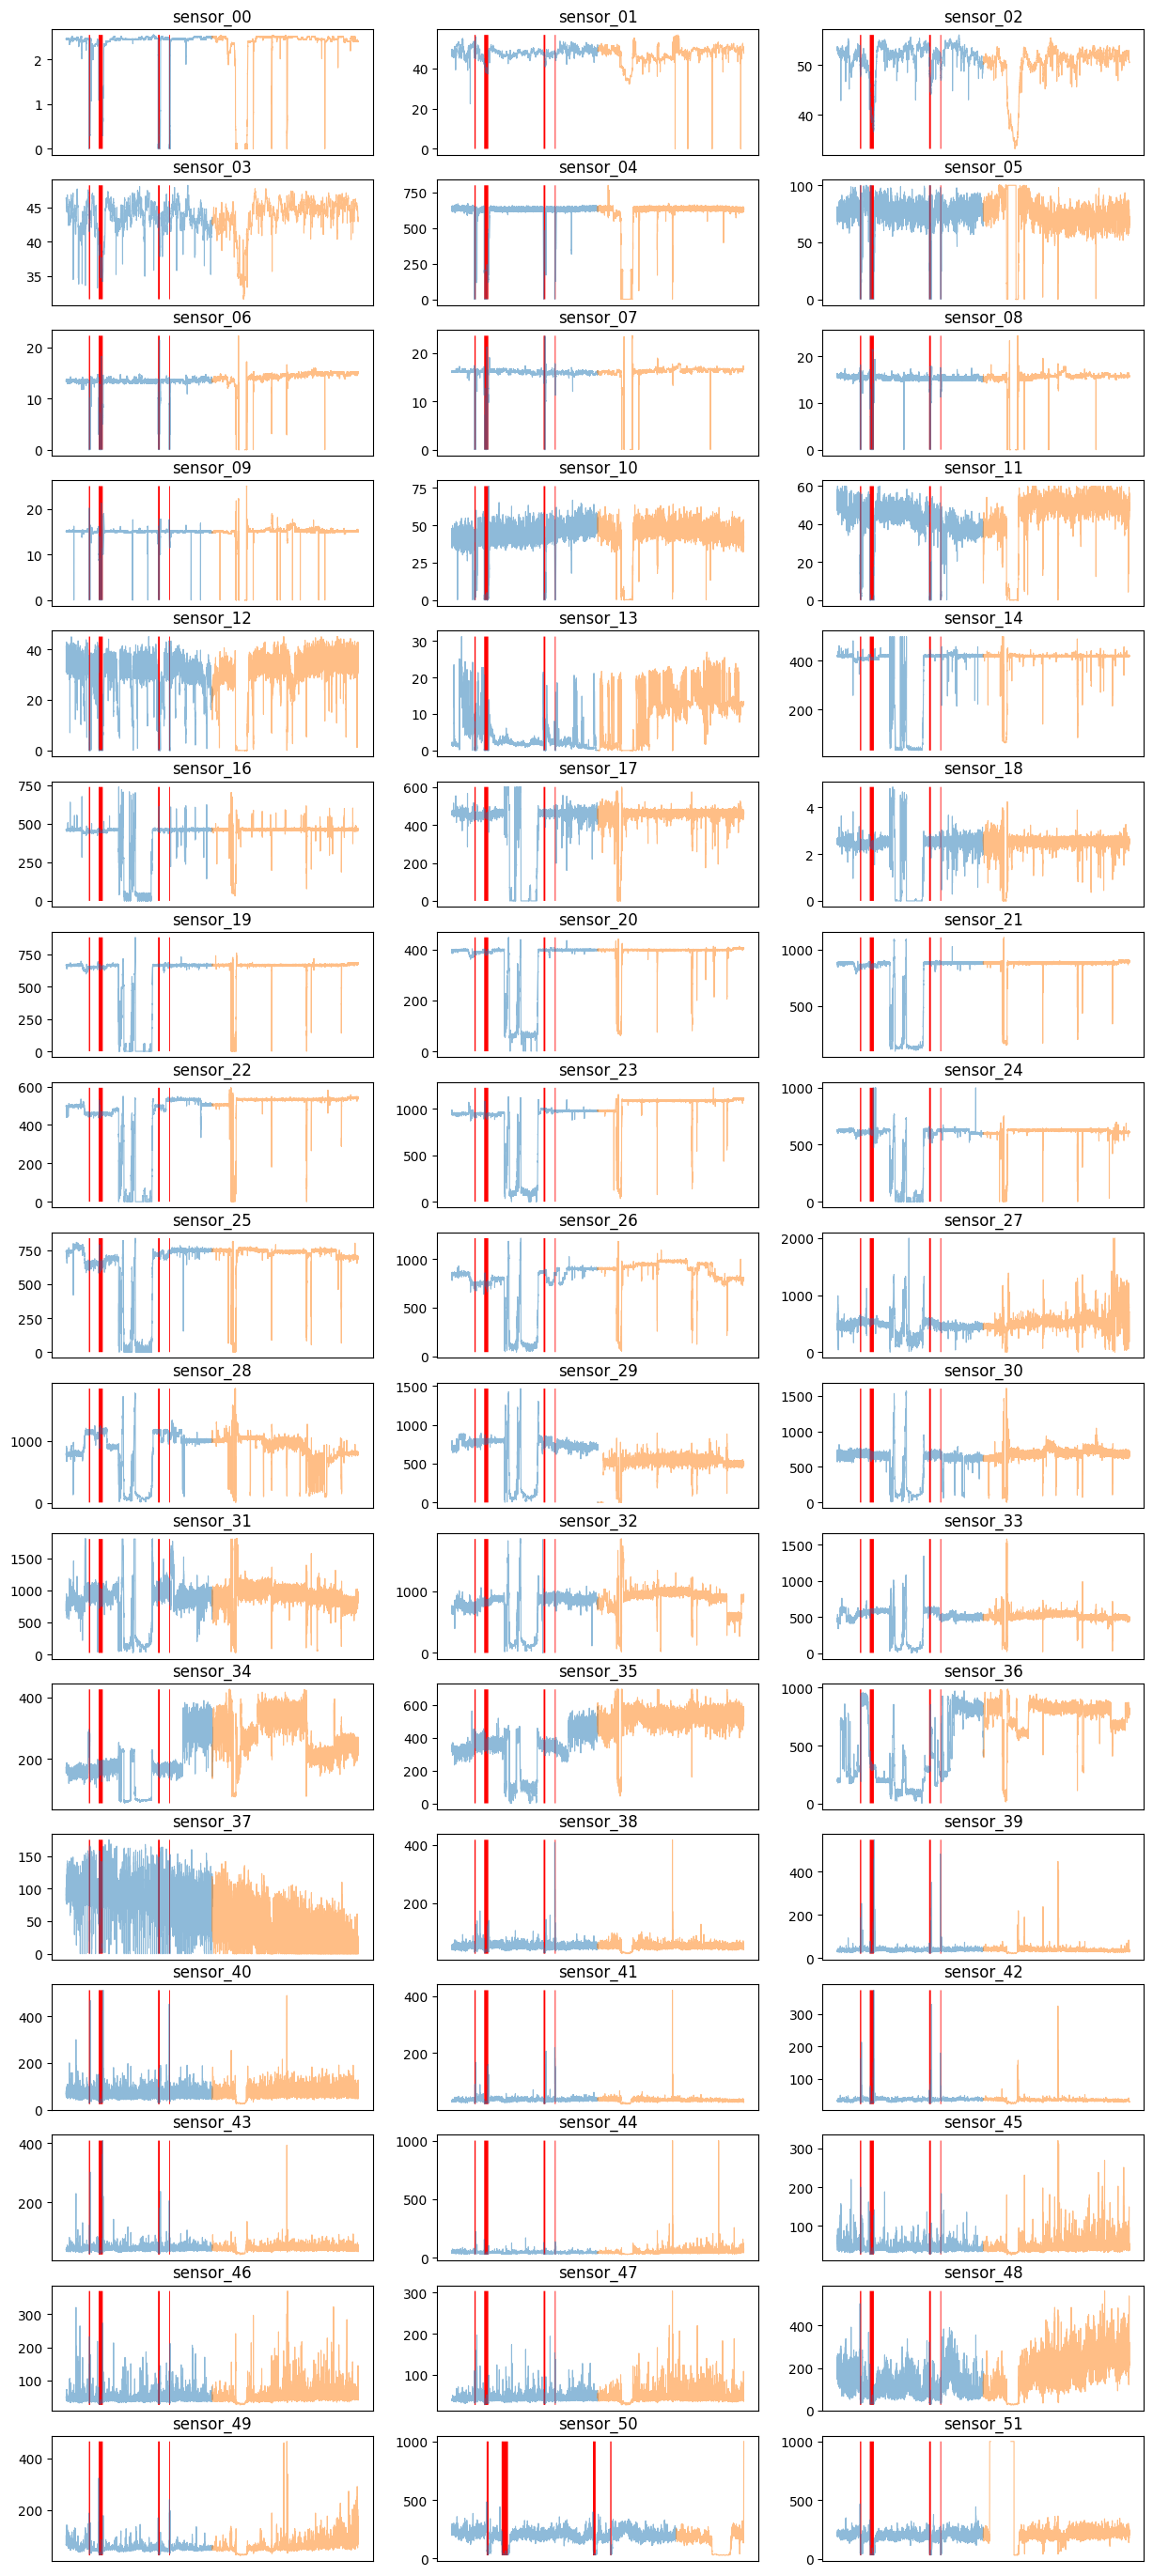

In [44]:
# センサーごとの故障ポイント
x1 = len(train_set)
x2 = len(test_set)

broken_id = train_set[train_set.machine_status==1].index
broken_id_list = []
pre = 0
for c, i in enumerate(broken_id):
    if c != 0 and broken_id[c] != broken_id[c-1]+1:
        broken_id_list.append((broken_id[pre], broken_id[c-1]))
        pre = c
broken_id_list.append((broken_id[pre], broken_id[-1]))

fig, axes = plt.subplots(17, 3, figsize=(15, 35))
for ax, sensor in zip(axes.ravel(), data_set.columns[1:-1]):
    y1 = train_set[sensor]
    y2 = test_set[sensor]
    ax.set_title(sensor)
    ax.set_xticks([])
    ax.plot(range(x1), y1, linewidth=0.8, alpha=0.5)
    ax.plot(range(x1, x1+x2), y2, linewidth=0.8, alpha=0.5)
    for t in broken_id_list:
        ax.fill_between(np.arange(t[0], t[1]), data_set[sensor].min(), data_set[sensor].max(), facecolor='r')

sensor_00        -0.781624
sensor_01        -0.509490
sensor_02        -0.645803
sensor_03        -0.427237
sensor_04        -0.883270
sensor_05        -0.847467
sensor_06        -0.812866
sensor_07        -0.725806
sensor_08        -0.630039
sensor_09        -0.642243
sensor_10        -0.833702
sensor_11        -0.800252
sensor_12        -0.701190
sensor_13        -0.194575
sensor_14         0.116292
sensor_16         0.112929
sensor_17         0.097335
sensor_18         0.086556
sensor_19         0.117667
sensor_20         0.116905
sensor_21         0.114853
sensor_22         0.094085
sensor_23         0.115897
sensor_24         0.129151
sensor_25         0.083639
sensor_26         0.080979
sensor_27         0.086052
sensor_28         0.187960
sensor_29         0.115596
sensor_30         0.123974
sensor_31         0.102805
sensor_32         0.080307
sensor_33         0.130352
sensor_34         0.000685
sensor_35         0.075002
sensor_36        -0.055492
sensor_37         0.054459
s

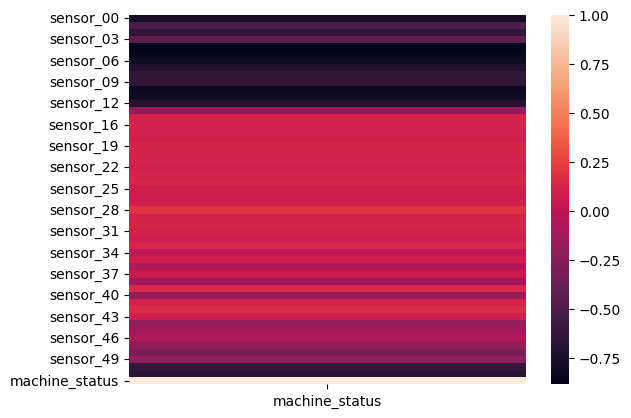

In [6]:
# 各特徴量とターゲット変数との相関係数 (訓練データ)
# 'RECOVERING'を異常とすると相関がはっきりと表れるようになった

heat_set = train_set.drop(['timestamp'], axis=1)
sns.heatmap(pd.DataFrame(heat_set.corr().loc['machine_status']))
sonsor_corr = heat_set.corr().loc['machine_status']
print(sonsor_corr)

# データ変換

In [7]:
# スケーリング
# 時系列データの特性上、後からデータが追加されるということを想定し、訓練データで学習した変換器を訓練/テストに用いている

sc = MinMaxScaler()
sc.fit(train_set.loc[:, 'sensor_00':'sensor_51'])
train_set.loc[:, 'sensor_00':'sensor_51'] = sc.transform(train_set.loc[:, 'sensor_00':'sensor_51'])
test_set.loc[:, 'sensor_00':'sensor_51'] = sc.transform(test_set.loc[:, 'sensor_00':'sensor_51'])

In [ ]:
# 欠損値補間①
# 時系列データに対する欠損値補間では様々なライブラリが豊富に存在する(前後補間、最近傍補間、線形補間、スプライン補間等)
# 今回のデータセット(220320 * 51)では、スプライン補間等の複雑な補間は膨大な計算時間を要するため、線形補間を行う
# 次元削減を補間の前に処理しておくと、スプライン補間もできるかも..?

data = pd.concat([train_set, test_set])
data = data.interpolate()
data.info()

In [8]:
# 特徴量抽出
# ターゲット変数との相関が強いセンサーを優先的に選択

sensor_list = ['timestamp']
for s in data_set.columns[1:]:
    if (sonsor_corr[s] < -0.5) | (sonsor_corr[s] > 0.5):
        sensor_list.append(s)

data = pd.concat([train_set, test_set])
data = data[sensor_list]
data = data.drop(['sensor_50'], axis=1) #sensor_50は欠損値が多い(全体の35%)ため除去
data

,timestamp,sensor_00,sensor_01,sensor_02,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,sensor_09,sensor_10,sensor_11,sensor_12,sensor_51,machine_status
0,2018-04-01 00:00:00,0.967194,0.739583,0.855233,0.943783,0.764598,0.626734,0.686154,0.726412,0.707483,0.489146,0.792070,0.691492,0.392430,0
1,2018-04-01 00:01:00,0.967194,0.739583,0.855233,0.943783,0.764598,0.626734,0.686154,0.726412,0.707483,0.489146,0.792070,0.691492,0.392430,0
2,2018-04-01 00:02:00,0.959089,0.747396,0.855233,0.950529,0.735461,0.622673,0.682154,0.728779,0.705442,0.497561,0.802954,0.713088,0.397742,0
3,2018-04-01 00:03:00,0.965264,0.739583,0.853006,0.934442,0.769891,0.622335,0.691077,0.732499,0.708844,0.506916,0.810935,0.703827,0.396414,0
4,2018-04-01 00:04:00,0.959475,0.740885,0.855233,0.946897,0.765891,0.624027,0.689539,0.732499,0.708844,0.518868,0.817716,0.710045,0.392430,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
220315,2018-08-31 23:55:00,0.944423,0.757812,0.717149,0.944302,0.645910,0.706599,0.708308,0.730470,0.712585,0.567240,0.902675,0.845650,0.460823,0
220316,2018-08-31 23:56:00,0.941721,0.757812,0.719376,0.938594,0.658337,0.708291,0.710462,0.730470,0.710544,0.567759,0.908767,0.856330,0.460823,0
220317,2018-08-31 23:57:00,0.940178,0.757812,0.717149,0.931156,0.672945,0.705245,0.710462,0.732499,0.710544,0.566682,0.918630,0.856151,0.462815,0
220318,2018-08-31 23:58:00,0.944037,0.757812,0.717149,0.945686,0.650918,0.706599,0.704615,0.734528,0.710544,0.556552,0.933220,0.864258,0.467463,0


In [9]:
# 欠損値補間②
# 51 -> 13次元に削減できたためスプライン補間

data = data.interpolate('spline', order=3)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220320 entries, 0 to 220319
Data columns (total 15 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   timestamp       220320 non-null  object 
 1   sensor_00       220320 non-null  float64
 2   sensor_01       220320 non-null  float64
 3   sensor_02       220320 non-null  float64
 4   sensor_04       220320 non-null  float64
 5   sensor_05       220320 non-null  float64
 6   sensor_06       220320 non-null  float64
 7   sensor_07       220320 non-null  float64
 8   sensor_08       220320 non-null  float64
 9   sensor_09       220320 non-null  float64
 10  sensor_10       220320 non-null  float64
 11  sensor_11       220320 non-null  float64
 12  sensor_12       220320 non-null  float64
 13  sensor_51       220320 non-null  float64
 14  machine_status  220320 non-null  int64  
dtypes: float64(13), int64(1), object(1)
memory usage: 25.2+ MB


In [10]:
# 移動平均による平滑化
# 突発的な外れ値や不規則な振動に頑健、かつ時系列上の流れをくみ取ったデータを生成できる

v = np.ones(5)/5.0 #後ろ５つ(自身含め)のデータで平滑化
data_smooth = copy.deepcopy(data)

for col in data.columns[1:-1]:
    data_smooth[col] = np.convolve(data_smooth[col], v, mode='same')

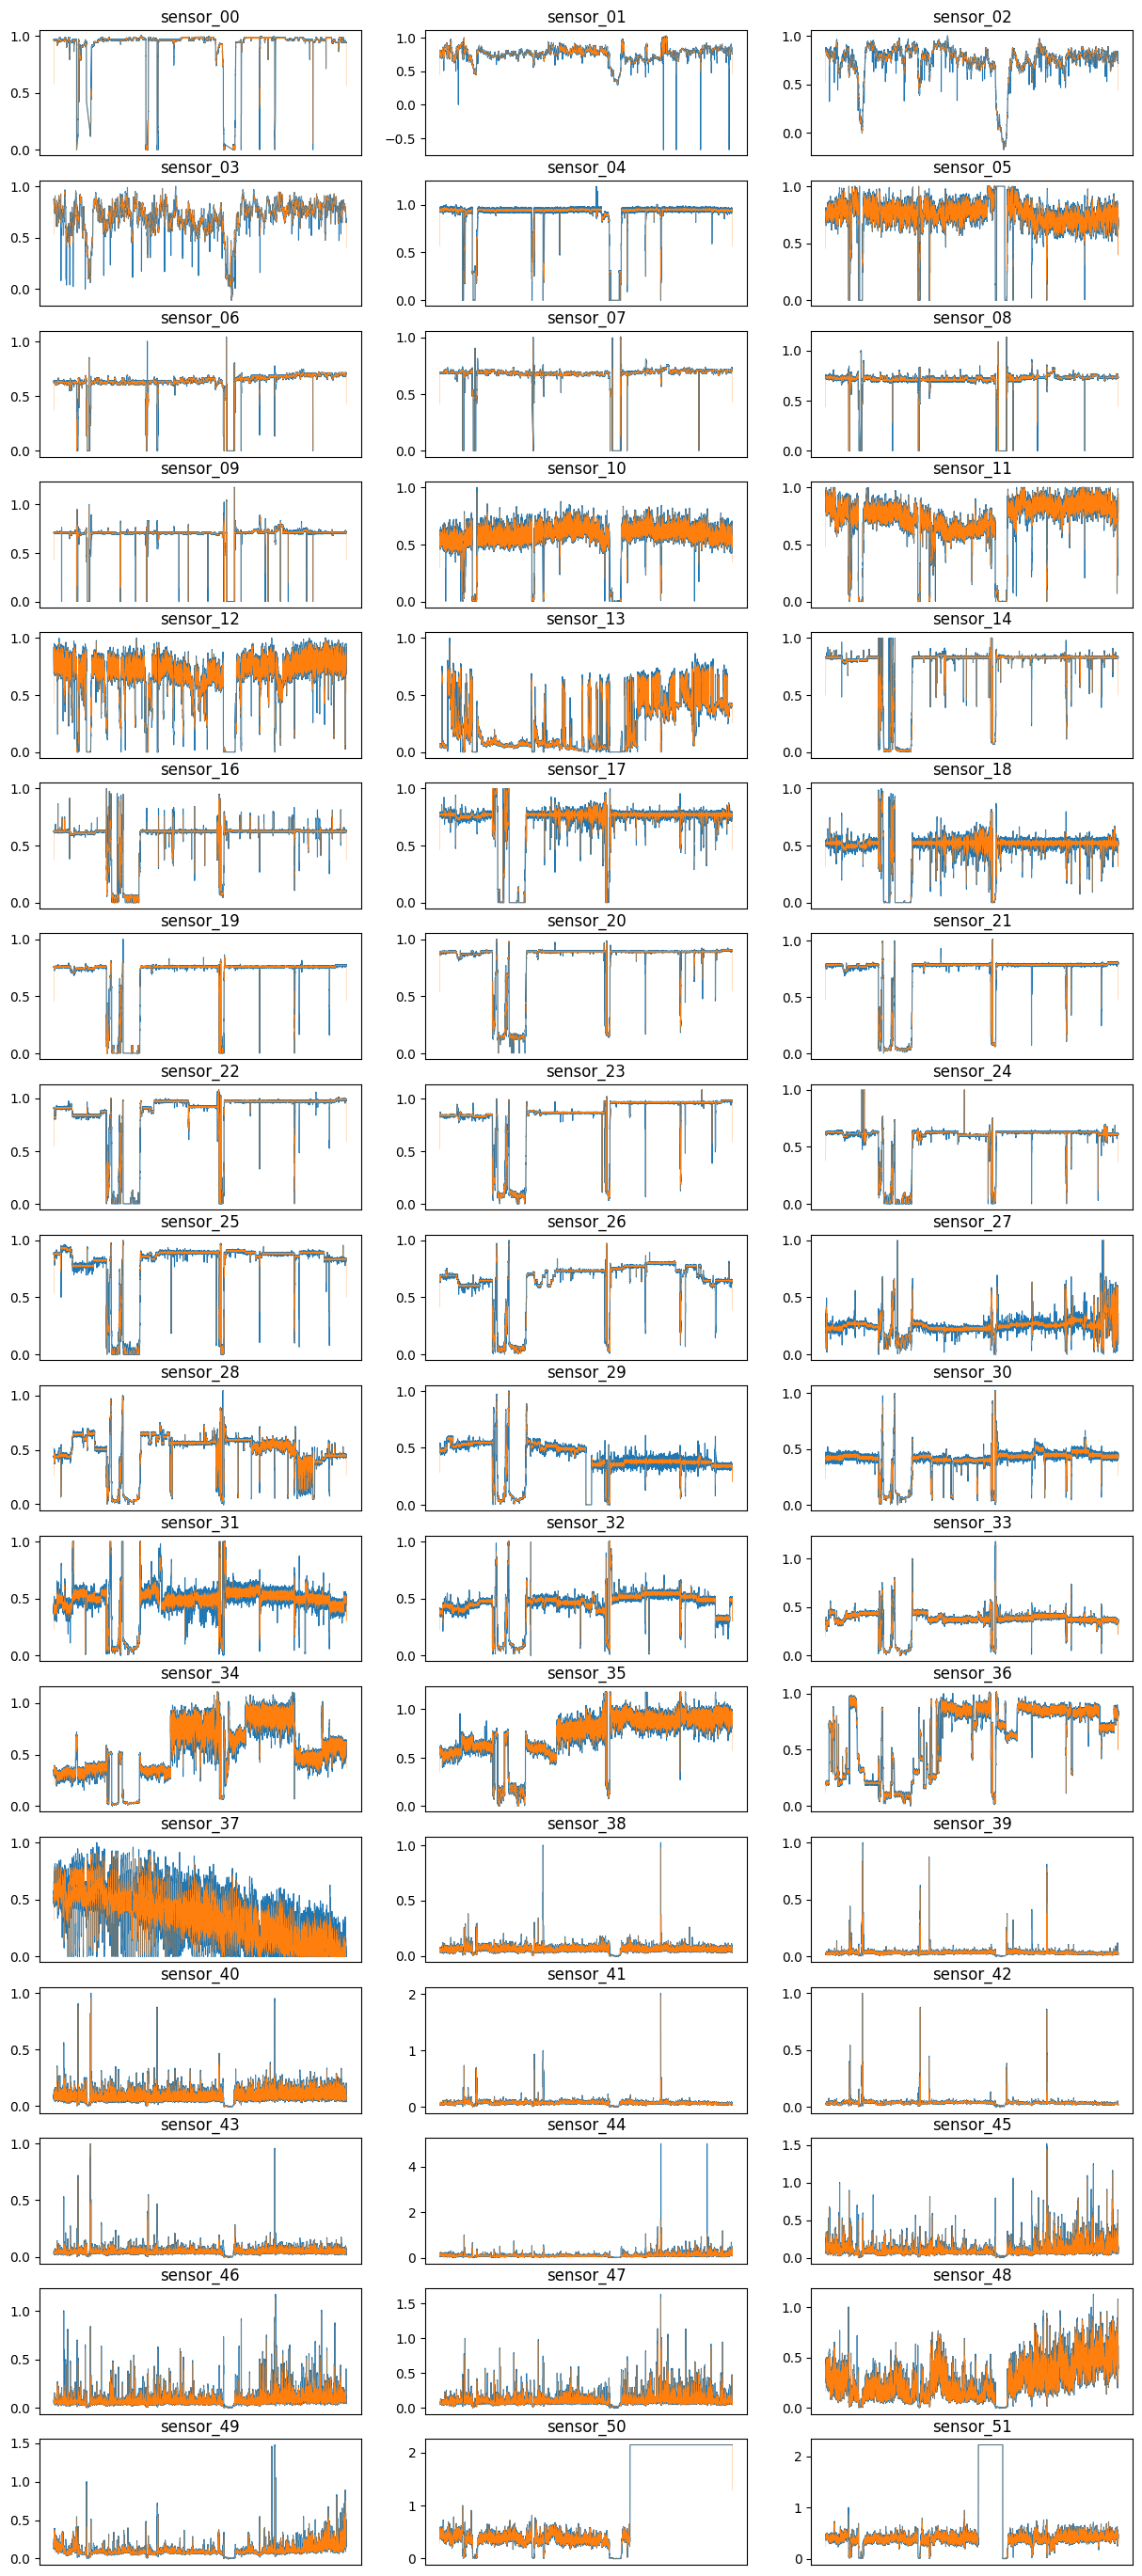

In [58]:
# 平滑化前後の変化(特徴量抽出なし + 線形補間)
# 端点の補正がうまく処理できていない (np.convolveには補正処理は含まれない. pd.rollingでも移動平均は可能だが窓関数の設定が難しい+補正は不明)

x = len(data)
fig, axes = plt.subplots(17, 3, figsize=(15, 35))
for ax, sensor in zip(axes.ravel(), data.columns[1:-1]):
    y1 = data[sensor]
    y2 = data_smooth[sensor]
    ax.set_title(sensor)
    ax.set_xticks([])
    ax.plot(range(x), y1, linewidth=0.8, zorder=1)
    ax.plot(range(x), y2, linewidth=0.2, zorder=2)

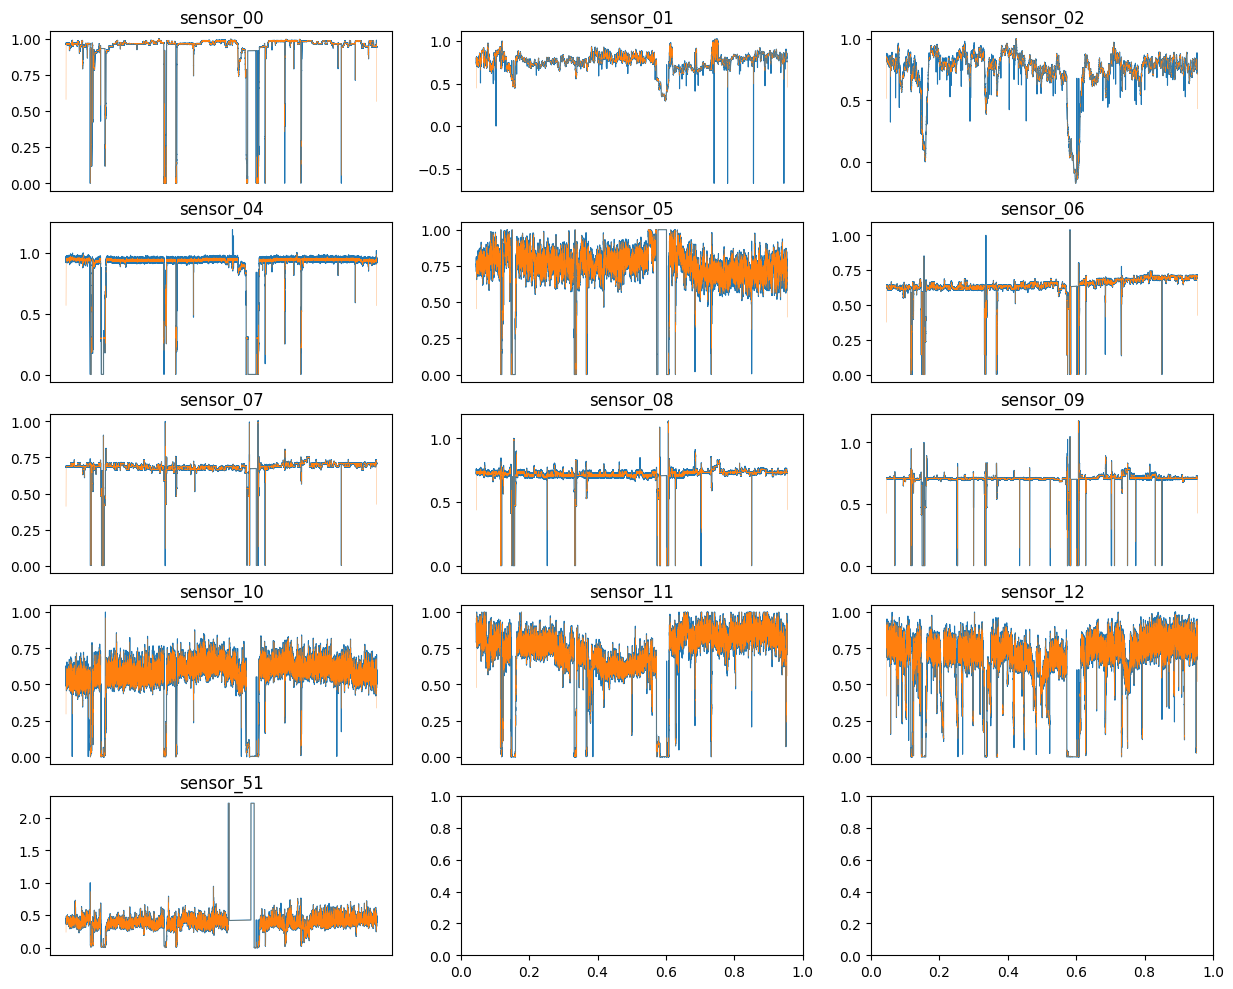

In [94]:
# 平滑化前後の変化(特徴量抽出あり + スプライン補間)
# 端点の補正がうまく処理できていない (np.convolveには補正処理は含まれない. pd.rollingでも移動平均は可能だが窓関数の設定が難しい+補正は不明)

x = len(data)
fig, axes = plt.subplots(5, 3, figsize=(15, 12))
for ax, sensor in zip(axes.ravel(), data.columns[1:-1]):
    y1 = data[sensor]
    y2 = data_smooth[sensor]
    ax.set_title(sensor)
    ax.set_xticks([])
    ax.plot(range(x), y1, linewidth=0.8, zorder=1)
    ax.plot(range(x), y2, linewidth=0.2, zorder=2)

# LightGBMによる異常検知

In [11]:
data_smooth

,timestamp,sensor_00,sensor_01,sensor_02,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,sensor_09,sensor_10,sensor_11,sensor_12,sensor_51,machine_status
0,2018-04-01 00:00:00,0.578696,0.445312,0.513140,0.567619,0.452932,0.375228,0.410892,0.436321,0.424082,0.295171,0.477419,0.419214,0.236521,0
1,2018-04-01 00:01:00,0.771748,0.593229,0.683741,0.754508,0.606910,0.499695,0.549108,0.582821,0.565850,0.396554,0.639606,0.559980,0.315803,0
2,2018-04-01 00:02:00,0.963644,0.741406,0.854788,0.943887,0.760088,0.624501,0.687015,0.729320,0.707619,0.500327,0.803149,0.701989,0.394290,0
3,2018-04-01 00:03:00,0.962717,0.741406,0.854343,0.944856,0.763540,0.624501,0.687323,0.732364,0.708639,0.505758,0.809303,0.706971,0.394422,0
4,2018-04-01 00:04:00,0.961945,0.741146,0.853897,0.944544,0.762252,0.624704,0.687323,0.733176,0.708912,0.508576,0.816128,0.710938,0.393891,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
220315,2018-08-31 23:55:00,0.942107,0.757292,0.718040,0.940081,0.648735,0.706125,0.708800,0.730064,0.711020,0.564735,0.901356,0.846311,0.456441,0
220316,2018-08-31 23:56:00,0.942107,0.757292,0.718040,0.941777,0.651348,0.706802,0.708062,0.730876,0.710612,0.564677,0.909938,0.853430,0.460956,0
220317,2018-08-31 23:57:00,0.942107,0.757812,0.717594,0.942330,0.656535,0.706666,0.708431,0.731687,0.709932,0.563668,0.920980,0.859631,0.463878,0
220318,2018-08-31 23:58:00,0.753223,0.606250,0.574165,0.753470,0.527353,0.565347,0.566769,0.585593,0.567415,0.450220,0.740445,0.690501,0.371713,0


In [12]:
# データ分割
train = copy.deepcopy(data_smooth.iloc[:int(len(data_smooth)/2)])
test = copy.deepcopy(data_smooth.iloc[int(len(data_smooth)/2):])

# 特徴量とターゲット変数に分割
X_train = copy.deepcopy(train.iloc[:, 1:-1])
y_train = copy.deepcopy(train.iloc[:, -1])

X_test = copy.deepcopy(test.iloc[:, 1:-1])
y_test = copy.deepcopy(test.iloc[:, -1])

In [13]:
# LGBMで計算できる形式にデータ変換
lgb_train = lgb.Dataset(X_train, y_train)

# パラメータ設定
params = {'objective': 'binary',
          'eval_metric': 'binary_logloss', #LogLoss: 分類予測の確実性を測る評価指標 ※他にも'auc'が選択可能
          'random_state': 42,
          'learning_rate': 0.01
          #'early_stopping_rounds': 20
         }

# 学習
model = lgb.train(params, lgb_train)

[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Info] Number of positive: 5975, number of negative: 104185
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011875 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3315
[LightGBM] [Info] Number of data points in the train set: 110160, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.054239 -> initscore=-2.858584
[LightGBM] [Info] Start training from score -2.858584


In [14]:
# 予測
y_pred = model.predict(X_test)

Correlation Coefficient: 0.981


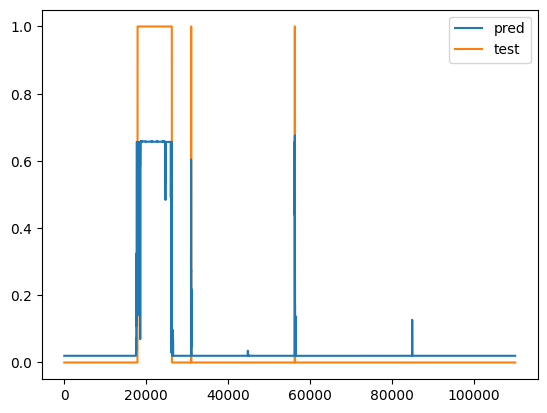

In [54]:
# 予測確率とテスト
plt.plot(range(len(y_pred)), y_pred, label='pred', zorder=2)
plt.plot(range(len(y_test)), y_test, label='test', zorder=1)
plt.legend()
print('Correlation Coefficient: {:.3f}'.format(np.corrcoef(np.array(y_test), y_pred)[0, 1]))

In [52]:
# 予測確率0.5以上であれば異常
y_pred_binary = np.array([0] * len(y_pred))
y_pred_binary[np.where(y_pred >= 0.5)[0]] = 1
#plt.plot(range(len(y_pred_binary)), y_pred_binary)
print(classification_report(y_test, y_pred_binary))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    101651
           1       0.97      0.99      0.98      8509

    accuracy                           1.00    110160
   macro avg       0.99      0.99      0.99    110160
weighted avg       1.00      1.00      1.00    110160



<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

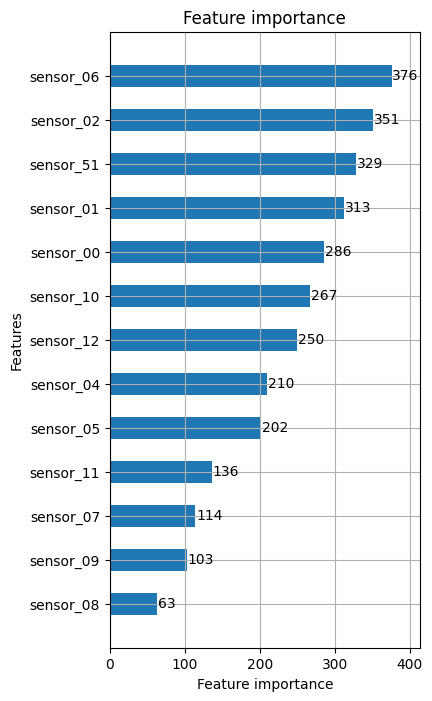

In [53]:
# 特徴量重要度
lgb.plot_importance(model, height=0.5, figsize=(4,8))